# Generating Training Data

In [1]:
import numpy as np

def get_y(x):
    return 10 + x*x


def sample_data(n=5000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

In [2]:
import tensorflow as tf
import numpy as np
#from training_data import *
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

In [3]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

# Generator and Discriminator Networks Implementation

In [4]:
# Generator network

# takes in the placeholder for random samples (Z)
# an array hsize for the number of units in the 2 hidden layers
# a reuse variable which is used for reusing the same layers

def generator(Z,hsize=[16, 16],reuse=False):
    
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

In [5]:
# Discriminator network

# 3 hidden layers for the Discriminator out of which first 2 layers size we take input
# the size of the third hidden layer to 2 so that we can visualize the transformed feature space in a 2D plane
# The output of this function is a logit prediction for the given X 
# the output of the last layer is the feature transformation learned by Discriminator for X.
# The logit function is the inverse of the sigmoid function which is used to represent the logarithm of the odds

def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3

# Adversarial Training

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
# create the graph for generating samples from Generator network 
# and feeding real and generated samples to the Discriminator network

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)


/Users/susman/opt/anaconda3/envs/GANS/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/susman/opt/anaconda3/envs/GANS/lib/python3.7/site-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/Users/susman/opt/anaconda3/envs/GANS/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/susman/opt/anaconda3/envs/GANS/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please us

In [8]:
# Define LOSS functions for the Generator and Discriminator networks 

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

# sigmoid cross entropy - discrete classification

In [9]:
# define the optimizers for the two networks

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

2022-04-30 18:07:19.642273: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


44

In [11]:
for i in range(5001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    print ("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dloss,gloss))

    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('iterations/iteration_%d.png'%i)
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('features/feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('features/feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()
    

Iterations: 0	 Discriminator loss: 0.7103	 Generator loss: 0.7098
Iterations: 1	 Discriminator loss: 0.6864	 Generator loss: 0.7265
Iterations: 2	 Discriminator loss: 0.6631	 Generator loss: 0.7501
Iterations: 3	 Discriminator loss: 0.6393	 Generator loss: 0.7760
Iterations: 4	 Discriminator loss: 0.5930	 Generator loss: 0.8153
Iterations: 5	 Discriminator loss: 0.5649	 Generator loss: 0.8526
Iterations: 6	 Discriminator loss: 0.5351	 Generator loss: 0.8890
Iterations: 7	 Discriminator loss: 0.5005	 Generator loss: 0.9356
Iterations: 8	 Discriminator loss: 0.4624	 Generator loss: 0.9990
Iterations: 9	 Discriminator loss: 0.4241	 Generator loss: 1.0735
Iterations: 10	 Discriminator loss: 0.3790	 Generator loss: 1.1696
Iterations: 11	 Discriminator loss: 0.3319	 Generator loss: 1.2897
Iterations: 12	 Discriminator loss: 0.2791	 Generator loss: 1.4443
Iterations: 13	 Discriminator loss: 0.2379	 Generator loss: 1.5946
Iterations: 14	 Discriminator loss: 0.1990	 Generator loss: 1.7584
Itera

# Analyzing GANs
## Visualizing the Training losses

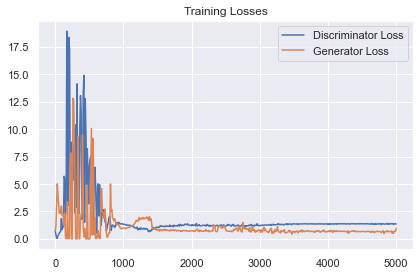

In [12]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
#from training_data import *
sb.set()


# data = sample_data(n=256)
#
# plt.scatter(data[:,0], data[:,1])

data = pd.read_csv('loss_logs.csv')

plt.plot('Iteration','Discriminator Loss',data=data)
plt.plot('Iteration','Generator Loss',data=data)

plt.legend()
plt.title('Training Losses')
plt.tight_layout()
# plt.savefig('../plots/dataset.png')
plt.savefig('training_loss.png')
plt.show()

# Convert to Gifs

In [13]:
from PIL import Image
import numpy as np

ipath = "features/feature_transform_%d.png"

import imageio
images = []
for i in range(11):
    images.append(imageio.imread(ipath%(i*1000)))
imageio.mimsave('images/feature_transform.gif', images, fps=2)


ipath = "features/feature_transform_centroid_%d.png"

images = []
for i in range(11):
    images.append(imageio.imread(ipath%(i*1000)))
imageio.mimsave('images/feature_transform_centroid.gif', images, fps=2)

ipath = "iterations/iteration_%d.png"

images = []
for i in range(11):
    images.append(imageio.imread(ipath%(i*1000)))
imageio.mimsave('images/iterations.gif', images, fps=2)

# Show raw data

In [14]:
np.array(data)

array([[0.000000e+00, 7.103420e-01, 7.098330e-01],
       [1.000000e+01, 3.790470e-01, 1.169600e+00],
       [2.000000e+01, 6.340700e-02, 2.976678e+00],
       ...,
       [4.980000e+03, 1.380273e+00, 7.251080e-01],
       [4.990000e+03, 1.386436e+00, 7.008280e-01],
       [5.000000e+03, 1.348287e+00, 9.793460e-01]])

In [15]:
G_sample

<tf.Tensor 'GAN/Generator/dense_2/BiasAdd:0' shape=(?, 2) dtype=float32>

In [16]:
print(tf.__version__)

2.8.0
